# Base models Qwen3-06B and Gemini API


This notebook is a **baseline evaluation** to assess the performance of pre-trained models (`gemini-2.0-flash` API, `Qwen3-065B` base, and our `Qwen-Lora-Estate` model) on the real estate price prediction task. 

The notebook performs the following steps:

1. Load dataset from remote (Kaggle/Hugging Face).
2. Preprocess dataset.
3. Evaluate **pre-trained base** `Qwen\Qwen3-0.6B` model using regression metrics.
4. Evaluate Gemini **API** using regression metrics.
5. Evaluate the performance of the **fine-tuned** `Qwen-Lora-Estate` model using regression metrics
6. Final models results and report the amount of improvement.

---
## Setup
---

### **Install Dependencies**

In [1]:
# !pip install -qU transformers wandb google-generativeai huggingface_hub[hf_xet]
!pip install -qU  json_repair

### **Import Dependencies**

In [2]:
import os
import json
import torch
import json_repair
import pandas as pd
from IPython.display import JSON
from tqdm import tqdm

from transformers import AutoModelForCausalLM, AutoTokenizer
import google.generativeai as genai

# my custom modules
from utils import logging_config, evaluate_model, timeit
from fine_tuning_helpers import apply_prompt_template, decode_response

In [3]:
os.environ['LOGS'] = '/kaggle/working/logs'
os.environ['RESULTS'] = '/kaggle/working/results'

os.makedirs(os.environ['LOGS'], exist_ok=True )
os.makedirs(os.environ['RESULTS'], exist_ok=True )

LOGGER = logging_config(log_dir=os.environ['LOGS'])
LOGGER

<_Logger utils (INFO)>

### **Define Tokens and Authenticate**

In [4]:
# If using kaggle 
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HUGGINGFACEHUB_API_TOKEN")
gemini_token = user_secrets.get_secret("GOOGLE_API_KEY")

# uncomment if using colab
# from google.colab import userdata
# hf_token = userdata.get("HUGGINGFACEHUB_API_TOKEN")
# gemini_token = userdata.get("GOOGLE_API_KEY")

In [5]:
from huggingface_hub import whoami, login

# !huggingface-cli login --token {mytoken} # another method
login(token = hf_token)
genai.configure(api_key=gemini_token)
# JSON(whoami())

In [20]:
# uncomment if using colab
# import kagglehub
# kagglehub.login(validate_credentials=True)

---
## Load Dataset
---

### Read data from remote (Kaggle/Hugging Face)

**Download the dataset from Kaggle**

In [ ]:
# # Uncomment if using colab

# kagglehub.dataset_download('hebamo7amed/real-estate-data-for-llm-fine-tuning')
# tabular_data_path = f"{data_path}/tabular_data"
# text_data_path = f"{data_path}/text_data"
# text_data_path

**Read Text Datasets**

In [ ]:
# with open(f"{text_data_path}/text_train_data.jsonl", "r") as f:
#   train_data = json.load(f)

# with open(f"{text_data_path}/text_val_data.jsonl", "r") as f:
#   val_data = json.load(f)

# with open(f"{text_data_path}/sample_50.jsonl", "r") as f:
#   sample_data = json.load(f)

# print("Training data size = ", len(train_data))
# print("Validation data size = ", len(val_data))
# print("Sample data size = ", len(sample_data))

### **Load Dataset Sample from hugging Face Hub**

A data sample that was created from structured real estate data and uploaded to Hugging Face in the first notebook. It is formatted for ion-based fine-tuning an LLM.

In [6]:
from datasets import load_dataset
dataset = load_dataset(
    path  ='heba1998/real-estate-data-sample-for-llm-fine-tuning'
)
dataset

README.md:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

llm_train_data.jsonl:   0%|          | 0.00/5.54M [00:00<?, ?B/s]

llm_val_data.jsonl:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['system', 'instruction', 'input', 'output', 'history'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['system', 'instruction', 'input', 'output', 'history'],
        num_rows: 200
    })
})

In [7]:
# Convert data to list of jsons or ``jsonl``
val_data = [sample for sample in dataset['validation']]
house_price = lambda sample : json_repair.loads(sample['output'])['estimated_house_price']
true_labels = [ house_price(sample) for sample in dataset['validation']]

---
## Evaluate Responses of `gemini-2.0-flash` Model
---

Evaluate the responses from Gemini API using regression metrics.

### **Helper Function to get responses from `genai` SDK API**

This function uses another function from the `fine_tuning_helpers.py` and `utils` utility scripts.

In [13]:
from fine_tuning_helpers import extract_house_price

@timeit
def batch_api_generate(model, data, model_id = 'gemini'):
    llm_predictions = []
    tokens_history = []
    bar_format = '{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    
    for idx, sample in enumerate(tqdm(data, total=len(data),
                                 desc=f"Get response from pre-trained `{model_id}` model",
                                 ncols=100, colour='green')):
        LOGGER.info("-"*50)
        LOGGER.info(f"Sample id {idx}")
        LOGGER.info("-"*50)
        # 1. PREPROCESSING: 
        # build the system and user prompt with the model chat template
        prompt= apply_prompt_template(sample)

        # 2. GENERATION: Generate response
        response = model.generate_content(prompt)
        text_response = response.candidates[0].content.parts[0].text

        # 4. POSTPROCESSING:  return only the output tokens and  exclude input ids
        LOGGER.info(f"Response text for sample id={idx} \n {text_response}" )
        
        # Clean response
        house_price = extract_house_price(text_response)
        LOGGER.info(f"\t>> Predicted price: {house_price}")
        llm_predictions.append(int(house_price))
        
        # Store metadata for expenses calculation
        tokens_history.append({
                'id': idx,
                'input_tokens': response.usage_metadata.prompt_token_count, 
                'output_tokens': response.usage_metadata.candidates_token_count,
                'total_tokens': response.usage_metadata.total_token_count
            })
            
        LOGGER.debug(f"Updated tokens history for {idx}")

    return llm_predictions, tokens_history

In [9]:
list(model.name for model in genai.list_models())

['models/chat-bison-001',
 'models/text-bison-001',
 'models/embedding-gecko-001',
 'models/gemini-1.0-pro-vision-latest',
 'models/gemini-pro-vision',
 'models/gemini-1.5-pro-latest',
 'models/gemini-1.5-pro-001',
 'models/gemini-1.5-pro-002',
 'models/gemini-1.5-pro',
 'models/gemini-1.5-flash-latest',
 'models/gemini-1.5-flash-001',
 'models/gemini-1.5-flash-001-tuning',
 'models/gemini-1.5-flash',
 'models/gemini-1.5-flash-002',
 'models/gemini-1.5-flash-8b',
 'models/gemini-1.5-flash-8b-001',
 'models/gemini-1.5-flash-8b-latest',
 'models/gemini-1.5-flash-8b-exp-0827',
 'models/gemini-1.5-flash-8b-exp-0924',
 'models/gemini-2.5-pro-exp-03-25',
 'models/gemini-2.5-pro-preview-03-25',
 'models/gemini-2.5-flash-preview-04-17',
 'models/gemini-2.5-flash-preview-04-17-thinking',
 'models/gemini-2.5-pro-preview-05-06',
 'models/gemini-2.0-flash-exp',
 'models/gemini-2.0-flash',
 'models/gemini-2.0-flash-001',
 'models/gemini-2.0-flash-exp-image-generation',
 'models/gemini-2.0-flash-lit

### **Generate Response using Gemini.**

Generate responses from `gemini-2.0-flash` in the validation dataset.

In [ ]:
import google.generativeai as genai
import numpy as np

Configs = genai.GenerationConfig(max_output_tokens=200)

model_id = "models/gemini-2.0-flash"
gemini = genai.GenerativeModel(model_name=model_id,
                               generation_config=Configs)

gemini_preds_list, gemini_history = batch_api_generate(gemini, val_data, model_id)

### **Evaluation Metrics for `gemini-2.0-flash` Model**

This function is implemented in the `utils.py` utility script.

In [ ]:
print("Actual Price", true_labels[:10])
print("Predicted Prices", gemini_preds_list[:10])

> **`-1`** indecate to that gemini didn't produce the result.

**Evaluation Metrics and Predictions for `gemini-2.0-flash-exp` Model**

In [89]:
gemini_results = evaluate_model(true_labels, gemini_preds_list)

gemini_results["n_samples"] = len(val_data)
gemini_results["eval_time (min)"] = 2.45
gemini_results["response_time (min)"] = 2.45 / len(val_data)
gemini_results["eval_device"] = "remote-api"
gemini_results["model_name"] = model_id.split('/')[-1]

gemini_results["in_token_limit"]= "~1M"
gemini_results["out_token_limit"]="~8K"
gemini_results["n_params"]= "~8B"
gemini_results["size"]="-"

JSON(gemini_results)

<IPython.core.display.JSON object>

In [75]:
gemini_preds = pd.DataFrame(gemini_history)
gemini_preds['y_actual'] = true_labels
gemini_preds['y_pred'] = gemini_preds_list

missed_prec = len(gemini_preds[gemini_preds['y_pred']==-1]) * 100 /len(val_data)
gemini_results["missing_pred(%)"] = missed_prec

print(f">>>>>> Gemini can't predict {missed_prec}% from the given data <<<<<<")
gemini_preds.head(5)

>>>>>> Gemini can't predict 70% from the given data <<<<<<


,id,input_tokens,output_tokens,total_tokens,y_actual,y_pred
0,0,244,264,508,2500000.0,55000
1,1,246,266,512,295000.0,128000
2,2,245,265,510,299900.0,85000
3,3,246,266,512,699000.0,85000
4,4,245,265,510,239000.0,85000


**Save `gemini-2.0-flash-exp` Results**

In [128]:
with open(f"{os.environ['RESULTS']}/gemini_results.json", 'w') as json_file:
    json.dump(gemini_results, json_file, indent=4)

gemini_preds.to_csv(f"{os.environ['RESULTS']}/gemini_preds.csv", index=False)

---
## Evaluate Responses from Pre-Trained Base LM `Qwen3-0.6B`
---

### **Helper Function to get responses for base model**

This function uses another function from the `fine_tuning_helpers.py` and `utils` utility scripts.

In [78]:
@timeit
def batch_generate(model, tokenizer, data, device, color = 'green'):
    predictions = []
    tokens_history = []
    bar_format = '{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    
    for idx, sample in enumerate(
                 tqdm(data, total=len(data),
                 desc="Get response from pre-trained `Qwen3-0.6B` model",
                 ncols=100, colour=color) ):
        
        # 1. PREPROCESSING: 
        # build the system and user prompt with the model chat template
        prompt = apply_prompt_template(sample)

        # 2. TOKENIZATION: Tokenize the text prompt message
        inputs = tokenizer([prompt], return_tensors="pt").to(device)
        n_input_tokens = len(inputs.input_ids[0])
        LOGGER.info(f"\t>> Tokenized to {n_input_tokens} tokens")
        
        # 3. GENERATION: Generate response
        response_tokens_ids = model.generate(
            inputs=inputs.input_ids,
            attention_mask=inputs.attention_mask,
        )
        n_output_tokens = len(response_tokens_ids[0])

        # 4. POSTPROCESSING: Return only the output tokens and  exclude input ids and then clean response
        response_text = decode_response(response_tokens_ids, inputs.input_ids, tokenizer)
        response_dict = json_repair.loads(response_text)            
        try:
            house_price = response_dict["estimated_house_price"]
        except:
            try:
                house_price = response_dict[0]["estimated_house_price"]
            except: 
                print(response_dict)
                house_price = -1
        predictions.append(int(house_price))
        
        # Store BAse model metadata for cost calculation
        tokens_history.append({
                'id': idx,
                'input_tokens': n_input_tokens, 
                'output_tokens': n_output_tokens,
                'total_tokens': n_input_tokens + n_output_tokens
            })
            
    return predictions, tokens_history

### **Load `Qwen3-0.6B` from Hugging Face**

In [79]:
model_id = "Qwen/Qwen3-0.6B"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the model and tokenizer
tokenizer_qwen = AutoTokenizer.from_pretrained(model_id)
model_qwen = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=None).to(device)

### **Generate Response using Pre-trained `Qwen3-0.6B`**

Generate responses from the base model `Qwen3-0.6B` in the validation dataset.

In [100]:
# Make batch prediction or text to number genration 
base_qwen_preds_list, base_qwen_history = batch_generate(model=model_qwen, 
                                                  tokenizer=tokenizer_qwen, 
                                                  data = val_data,
                                                  device = device, 
                                                  color = 'yellow')

Get response from pre-trained `Qwen3-0.6B` model: 100%|███████████| 200/200 [02:40<00:00,  1.25it/s]


 Data completed in 2.67 minutes.


> Prediction for 200 sample takes 2.82 minutes using pretrained `Qwen3-0.6B`.

### **Evaluation metrics for Pre-trained `Qwen3-0.6B`**

This function is implemented in the `utils.py` utility script.

**Predictions sample**

In [104]:
print("Actual Price", true_labels[:10])
print("Predicted Prices", base_qwen_preds_list[:10])

Actual Price [2500000.0, 295000.0, 299900.0, 699000.0, 239000.0, 11000.0, 470000.0, 449000.0, 250000.0, 339000.0]
Predicted Prices [30000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000, 85000]


**Evaluation Metrics Results for Pre-trained `Qwen3-0.6B`**

In [133]:
base_qwen_results = evaluate_model(true_labels, base_qwen_preds_list)

base_qwen_results["n_samples"] = len(val_data)
base_qwen_results["eval_time (min)"] = 2.82
base_qwen_results["response_time (min)"] = 2.82 / len(val_data)
base_qwen_results["eval_device"] = "gpu-t4x2"
base_qwen_results["model_name"] = model_id.split('/')[-1]

base_qwen_results["in_token_limit"]= "~32K"
base_qwen_results["out_token_limit"]="~8"
base_qwen_results["n_params"]= "0.8B (600M)"
base_qwen_results["size"]="~1.5 GB"

JSON(base_qwen_results)

<IPython.core.display.JSON object>

> Model produce bad result and don't follow the output schema

> Model predict the same value each time `85000` or `8500` because it is bais towards the example of the schema.

In [138]:
base_qwen_preds = pd.DataFrame(base_qwen_history )
base_qwen_preds['y_actual'] = true_labels
base_qwen_preds['y_pred'] = base_qwen_preds_list

missed_prec = len(base_qwen_preds[base_qwen_preds['y_pred']==-1]) * 100 /len(val_data)
base_qwen_results["missing_pred(%)"] = missed_prec

print(f">>>>>> Base Qwen can't predict {missed_prec}% from the given data <<<<<<")
base_qwen_preds.sample(5)

>>>>>> Base Qwen can't predict 0.0% from the given data <<<<<<


,id,input_tokens,output_tokens,total_tokens,y_actual,y_pred
14,14,246,266,512,159900.0,85000
75,75,227,247,474,159900.0,85000
35,35,242,262,504,165000.0,85000
165,165,246,266,512,815000.0,85000
19,19,246,266,512,2200000.0,85000


**Save Pre-trained`Qwen3-0.6B` Results**

In [139]:
with open(f"{os.environ['RESULTS']}/base_qwen_results.json", 'w') as json_file:
    json.dump(base_qwen_results, json_file, indent=4)

base_qwen_preds.to_csv(f"{os.environ['RESULTS']}/base_qwen_preds.csv", index=False)

---
## Evaluate Responses from Fine-Tuned `Qwen3-0.6B`
---

### **Helper Function to get responses for base model**

This function uses another function from the `fine_tuning_helpers.py` and `utils` utility scripts.

### **Load our Adaptor `Qwen-LoRA-Estate` from Hugging Face**
Load the fine-tuned model from Hugging Face. The model is trained on the same dataset and schema as the base model.

In [109]:
from peft import PeftModel

adaptor_id = "heba1998/Qwen-LoRA-Estate"

# Load the LoRA adapter
peft_model =  PeftModel.from_pretrained(model_qwen, adaptor_id)

# Attach the LoRA adapter to the model
qwen_lora_estate = peft_model.merge_and_unload()

### **Generate Response using Fine-Tuned `Qwen3-0.6B`.**

Generate responses from the Fine-Tuned `Qwen3-0.6B` in the validation dataset.

In [32]:
# Make batch prediction or text to number genration
qwen_lora_preds_list, qwen_lora_history = batch_generate(model=qwen_lora_estate,
                                                            tokenizer=tokenizer_qwen,
                                                            data=val_data,
                                                            device=device,
                                                            color = 'blue')

Get response from pre-trained `Qwen3-0.6B` model: 100%|███████████| 200/200 [02:39<00:00,  1.25it/s]


 Data completed in 2.67 minutes.


> Prediction for 200 sample takes 3.01 minutes using our fine-tined lora qwen model `Qwen-lora-estate`.

### **Evaluation metrics for Fine-Tuned `Qwen3-0.6B`**

This function is implemented in the `utils.py` utility script.

In [113]:
print("Actual Price", true_labels[:10])
print("Predicted Prices", qwen_lora_preds_list[:10])

Actual Price [2500000.0, 295000.0, 299900.0, 699000.0, 239000.0, 11000.0, 470000.0, 449000.0, 250000.0, 339000.0]
Predicted Prices [125000, 269900, 289900, 799000, 225000, 16000, 445000, 399900, 199000, 279900]


**Evaluation Metrics and Predictions for our `Qwen-lora-estate` Model**

In [115]:
qwen_lora_results = evaluate_model(true_labels, qwen_lora_preds_list)

qwen_lora_results["n_samples"] = len(val_data)
qwen_lora_results["eval_time (min)"] = 2.82
qwen_lora_results["response_time (min)"] = 2.82 / len(val_data)
qwen_lora_results["eval_device"] = "gpu-t4x2"
qwen_lora_results["model_name"] = adaptor_id.split('/')[-1]

qwen_lora_results["in_token_limit"]= "~32K"
qwen_lora_results["out_token_limit"]="~8"
qwen_lora_results["n_params"]= "0.8B (600M)"
qwen_lora_results["size"]="~1.5 GB + 160M"

JSON(qwen_lora_results)

<IPython.core.display.JSON object>

In [118]:
qwen_lora_preds = pd.DataFrame(qwen_lora_history)
qwen_lora_preds['y_actual'] = true_labels
qwen_lora_preds['y_pred'] = qwen_lora_preds_list

missed_prec = len(qwen_lora_preds[qwen_lora_preds['y_pred']==-1]) * 100 /len(val_data)
qwen_lora_results["missing_pred(%)"] = missed_prec

print(f">>>>>> Base Qwen can't predict {missed_prec}% from the given data <<<<<<")

qwen_lora_preds.head(5)

>>>>>> Base Qwen can't predict 0.0% from the given data <<<<<<


,id,input_tokens,output_tokens,total_tokens,y_actual,y_pred
0,0,244,264,508,2500000.0,125000
1,1,246,266,512,295000.0,269900
2,2,245,265,510,299900.0,289900
3,3,246,266,512,699000.0,799000
4,4,245,265,510,239000.0,225000


**Save Results for our `Qwen-lora-estate` Model**

In [119]:
with open(f"{os.environ['RESULTS']}/qwen_lora_results.json", 'w') as json_file:
    json.dump(qwen_lora_results, json_file, indent=4)

qwen_lora_preds.to_csv(f"{os.environ['RESULTS']}/qwen_lora_preds.csv", index=False)

---
## Conclusion and Comparison
---

In this section, we will compare the performance of the models (`gemini-2.0-flash-exp`, `Qwen3-0.6B`, and `Qwen3-lora-estate-0.6B`) based on key evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R² score, and the percentage of missing predictions. The comparison will highlight the improvements achieved by the fine-tuned model (`Qwen3-lora-estate-0.6B`) over the base models. Additionally, we will analyze the **evaluation time**, **response time**, and **device used for inference** to assess the computational efficiency of each model.


In [129]:
json_files = []

for root, dirs, files in os.walk('results'):
    for file in files:
        if file.endswith('_results.json'):
            json_files.append(file)

json_files

['qwen_lora_results.json', 'gemini_results.json', 'base_qwen_results.json']

**Save All models results**

In [140]:
results = []

for filepath in json_files:
    with open(f"{os.environ['RESULTS']}/{filepath}", 'r') as f:
        results.append(json.load(f))

df_results = pd.DataFrame(results)
df_results.set_index('model_name', inplace=True)

df_results.to_csv(f"{os.environ['RESULTS']}/results_comparisons.csv", index=False)
df_results

,MSE,RMSE,MAE,R2,n_samples,eval_time (min),response_time (min),eval_device,in_token_limit,out_token_limit,n_params,size,missing_pred(%)
model_name,,,,,,,,,,,,,
Qwen-LoRA-Estate,1.659156e+11,407327.432745,198903.515,0.404099,200,2.82,0.01410,gpu-t4x2,~32K,~8,0.8B (600M),~1.5 GB + 160M,0.0
gemini-2.0-flash,4.047330e+11,636186.277290,390199.940,-0.453635,200,2.45,0.01225,remote-api,~1M,~8K,~8B,-,70.0
Qwen3-0.6B,4.292255e+11,655153.018002,403870.530,-0.541602,200,2.82,0.01410,gpu-t4x2,~32K,~8,0.8B (600M),~1.5 GB,0.0


**Improvements  Calculattion**

In [215]:
improvement = pd.DataFrame()
metrics = ['MSE', 'RMSE', 'MAE', 'R2']

qwen_lora = df_results.loc['Qwen-LoRA-Estate']

for metric in metrics:
    improvement[metric] = abs(qwen_lora[metric] - df_results[metric]) / qwen_lora[metric] * 100

improvement['missing_pred(%)'] = abs(qwen_lora['missing_pred(%)'] - df_results['missing_pred(%)'])

improvement = improvement.round(1)
improvement = improvement.drop('Qwen-LoRA-Estate')
improvement

,MSE,RMSE,MAE,R2,missing_pred(%)
model_name,,,,,
gemini-2.0-flash,143.9,56.2,96.2,212.3,70.0
Qwen3-0.6B,158.7,60.8,103.0,234.0,0.0


**Visual Improvement Report**

/tmp/ipykernel_30/1702958674.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


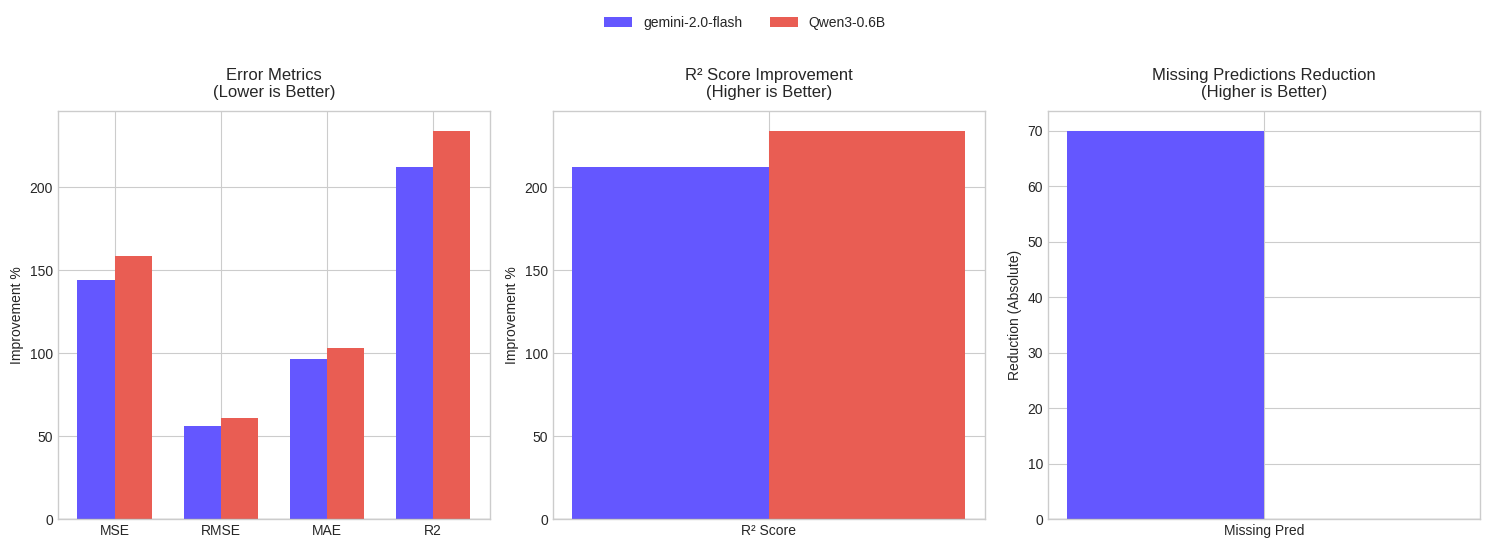

In [239]:
plt.style.use('seaborn-whitegrid')
qwen_palette = ['#6457ff', '#e95d53']# ['#1f77b4', '#ff7f0e'] 
bar_width = 0.35
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Error Metrics Plot
metrics_err = improvement.columns[:-1]
x = np.arange(len(metrics_err))
for i, model in enumerate(improvement.index):
    ax1.bar(x + i*bar_width, improvement.loc[model, metrics_err], 
            width=bar_width, color=qwen_palette[i], label=model)

ax1.set_title('Error Metrics\n(Lower is Better)', fontsize=12, pad=10)
ax1.set_xticks(x + bar_width/2)
ax1.set_xticklabels(metrics_err)
ax1.set_ylabel('Improvement %')
ax1.axhline(0, color='black', linewidth=0.8)

# R² Score Plot 
x = np.arange(1)
for i, model in enumerate(improvement.index):
    ax2.bar(x + i*bar_width, improvement.loc[model, 'R2'], 
            width=bar_width, color=qwen_palette[i], label=model)

ax2.set_title('R² Score Improvement\n(Higher is Better)', fontsize=12, pad=10)
ax2.set_xticks(x + bar_width/2)
ax2.set_xticklabels(['R² Score'])
ax2.set_ylabel('Improvement %')
ax2.axhline(0, color='black', linewidth=0.8)

# Missing Predictions Plot (Right)
x = np.arange(1)  # Single metric
for i, model in enumerate(improvement.index):
    ax3.bar(x + i*bar_width, improvement.loc[model, 'missing_pred(%)'], 
            width=bar_width, color=qwen_palette[i], label=model)

ax3.set_title('Missing Predictions Reduction\n(Higher is Better)', fontsize=12, pad=10)
ax3.set_xticks(x + bar_width/2)
ax3.set_xticklabels(['Missing Pred'])
ax3.set_ylabel('Reduction (Absolute)')
ax3.axhline(0, color='black', linewidth=0.8)

# Add single legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.savefig(f"{os.environ['RESULTS']}/qwen_3panel_comparison.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [240]:
# to be downolad for further comparasions
!zip /kaggle/working/results_200.zip /kaggle/working/results/*

updating: kaggle/working/results/gemini_metrics.json (deflated 27%)
updating: kaggle/working/results/gemini_results.csv (deflated 78%)
updating: kaggle/working/results/pretrained_qwen_metrics.json (deflated 37%)
updating: kaggle/working/results/pretrained_qwen_results.csv (deflated 78%)
updating: kaggle/working/results/results_metadata.json (deflated 25%)
updating: kaggle/working/results/qwen_lora_estate_metrics.json (deflated 36%)
updating: kaggle/working/results/qwen_lora_estate_results.csv (deflated 72%)
updating: kaggle/working/results/base_qwen_preds.csv (deflated 78%)
updating: kaggle/working/results/base_qwen_results.json (deflated 39%)
updating: kaggle/working/results/gemini_preds.csv (deflated 78%)
updating: kaggle/working/results/gemini_results.json (deflated 40%)
updating: kaggle/working/results/qwen_lora_preds.csv (deflated 72%)
updating: kaggle/working/results/qwen_lora_results.json (deflated 39%)
updating: kaggle/working/results/results_comparisons.csv (deflated 38%)
upda

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [241]:
from IPython.display import FileLink

# Create download link
FileLink('results_200.zip')

/kaggle/working/results_200.zip